In [1]:
%matplotlib inline


=======================================================================
Shrinkage covariance estimation: LedoitWolf vs OAS and max-likelihood
=======================================================================

When working with covariance estimation, the usual approach is to use
a maximum likelihood estimator, such as the
:class:`sklearn.covariance.EmpiricalCovariance`. It is unbiased, i.e. it
converges to the true (population) covariance when given many
observations. However, it can also **be beneficial to regularize it, in
order to reduce its variance**; this, in turn, introduces some bias. This
example illustrates the simple regularization used in
:ref:`shrunk_covariance` estimators. In particular, it focuses on how to
set the amount of regularization, i.e. how to choose the bias-variance
trade-off.

Here we compare 3 approaches:

* Setting the parameter by cross-validating the likelihood on three folds
  according to a grid of potential shrinkage parameters.

* A close formula proposed by Ledoit and Wolf to compute
  the asymptotically optimal regularization parameter (minimizing a MSE
  criterion), yielding the :class:`sklearn.covariance.LedoitWolf`
  covariance estimate.

* An improvement of the Ledoit-Wolf shrinkage, the
  :class:`sklearn.covariance.OAS`, proposed by Chen et al. Its
  convergence is significantly better under the assumption that the data
  are Gaussian, in particular for small samples.

To quantify estimation error, we plot the likelihood of unseen data for
different values of the shrinkage parameter. We also show the choices by
cross-validation, or with the LedoitWolf and OAS estimates.

Note that the maximum likelihood estimate corresponds to no shrinkage,
and thus performs poorly. The Ledoit-Wolf estimate performs really well,
as it is close to the optimal and is computational not costly. In this
example, the OAS estimate is a bit further away. Interestingly, both
approaches outperform cross-validation, which is significantly most
computationally costly.



In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, \
    log_likelihood, empirical_covariance
from sklearn.model_selection import GridSearchCV

Automatically created module for IPython interactive environment


Generate sample data


In [3]:
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

Compute the likelihood on test data


In [4]:
# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# under the ground-truth model, which we would not have access to in real
# settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

Compare different approaches to setting the parameter


In [5]:
# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{'shrinkage': shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

Plot results


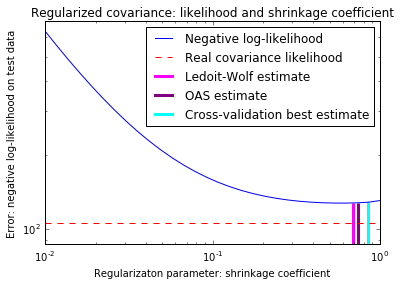

In [6]:
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularizaton parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')
# range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], '--r',
         label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]
# LW likelihood
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta',
           linewidth=3, label='Ledoit-Wolf estimate')
# OAS likelihood
plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple',
           linewidth=3, label='OAS estimate')
# best CV estimator likelihood
plt.vlines(cv.best_estimator_.shrinkage, ymin,
           -cv.best_estimator_.score(X_test), color='cyan',
           linewidth=3, label='Cross-validation best estimate')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()